In [1]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
from torchvision.transforms.functional import pad as PAD
import torch.optim as optim
from torch.utils.data.dataset import random_split
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
import re
import pandas as pd
from sklearn.metrics import classification_report
import wandb
import numbers
os.environ['CUDA_VISIBLE_DEVICES']='1'

from efficientnet_pytorch import EfficientNet

PyTorch Version:  1.4.0


In [2]:
hyperparameter_defaults = dict(
    input_size = 1024,
    batch_size = 1,
)
os.environ['WANDB_NOTEBOOK_NAME']='Testing Notebook'
wandb.init(project="Pick Best Epoch",config=hyperparameter_defaults)

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Currently logged in as: szho6430 (use `wandb login --relogin` to force relogin)


In [3]:
wbconfig = wandb.config

In [4]:
input_size = wbconfig.input_size
batch_size = wbconfig.batch_size
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
meta = pd.read_csv('./meta.csv',dtype={'Image No.':str})
meta['Img Name'] = meta['Image No.']+'.jpg'
meta['Direct'] = np.nan
meta['MURA'] = np.nan
meta.head()

,Patient No.,Species,Breed,Age (yrs),Gender,Neuter,Image Findings,Thoracic or Pelvic,Image No.,Normal_Abnormal,Test_CV,Img Name,Direct,MURA
0,1,Canine,German Shepherd,2,Female,Yes,Osteochondrosis with Osteophytes,Thoracic,001,False,4,001.jpg,NaN,NaN
1,1,Canine,German Shepherd,2,Female,Yes,Osteochondrosis with Osteophytes,Thoracic,002,False,1,002.jpg,NaN,NaN
2,1,Canine,German Shepherd,2,Female,Yes,Osteochondrosis with Osteophytes,Thoracic,003,False,3,003.jpg,NaN,NaN
3,1,Canine,German Shepherd,2,Female,Yes,Osteochondrosis with Osteophytes,Thoracic,004,False,3,004.jpg,NaN,NaN
4,1,Canine,German Shepherd,2,Female,Yes,Osteochondrosis with Osteophytes,Thoracic,005,False,4,005.jpg,NaN,NaN


In [6]:
def get_padding(image):    
    w, h = image.size
    max_wh = np.max([w, h])
    h_padding = (max_wh - w) / 2
    v_padding = (max_wh - h) / 2
    l_pad = h_padding if h_padding % 1 == 0 else h_padding+0.5
    t_pad = v_padding if v_padding % 1 == 0 else v_padding+0.5
    r_pad = h_padding if h_padding % 1 == 0 else h_padding-0.5
    b_pad = v_padding if v_padding % 1 == 0 else v_padding-0.5
    padding = (int(l_pad), int(t_pad), int(r_pad), int(b_pad))
    return padding

class NewPad(object):
    def __init__(self, fill=0, padding_mode='constant'):
        assert isinstance(fill, (numbers.Number, str, tuple))
        assert padding_mode in ['constant', 'edge', 'reflect', 'symmetric']

        self.fill = fill
        self.padding_mode = padding_mode
        
    def __call__(self, img):
        """
        Args:
            img (PIL Image): Image to be padded.

        Returns:
            PIL Image: Padded image.
        """
        return PAD(img, get_padding(img), self.fill, self.padding_mode)
    
    def __repr__(self):
        return self.__class__.__name__ + '(padding={0}, fill={1}, padding_mode={2})'.\
            format(self.fill, self.padding_mode)
from torchvision.transforms import ToPILImage
ToPILImage = ToPILImage()


def invTrans(image):
    transformation = transforms.Compose([transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.1402, 1/0.1402, 1/0.1402 ]),
                                         transforms.Normalize(mean = [ -0.1523, -0.1523, -0.1523 ],
                                                     std = [ 1., 1., 1. ]),
                               ])
    image = transformation(image)
    return image

def test(dataframes,strategy,cv,epoch,model,dataloaders, device):
    idx=0
    total = 0
    num_correct = 0
    for _,param in model.named_parameters():
        param.requires_grad = False
    model.to(device)
    model.eval()
    for inputs,label in dataloaders['test']:
        inputs = inputs.to(device)
        total += 1
        outputs = model(inputs)
        _,pred = torch.max(outputs,1)
        pred = pred.to('cpu').detach() 
        if torch.equal(pred,label.data):
            num_correct += 1
    accuracy = num_correct/total
    dataframes[strategy][cv].loc[dataframes[strategy][cv]['Epoch']==epoch,'Accuracy'] = accuracy
    return dataframes
    
data_transforms = {
    'test': transforms.Compose([
        NewPad(),
        transforms.Resize(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.1523, 0.1523, 0.1523], [0.1402, 0.1402, 0.1402])
    ]),
}



In [7]:
dataframes = {}
cv_dir = "/media/dasleo/LEOHDD/data/AnimalDatasetV2CVs/"
for strategy in ['Direct','MURA']:
    dataframes[strategy]={}
    for cv in np.arange(1,6):
        '''Step 1: Build up dataset and dataloader'''
        data_dir = cv_dir+'CV'+str(cv)
        image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), 
                                                  data_transforms[x]) for x in ['test']}
        dataloaders_dict = {}
        dataloaders_dict['test'] = torch.utils.data.DataLoader(image_datasets['test'],
                                                           batch_size=1,
                                                           shuffle=False,
                                                           num_workers=2)
        dataframes[strategy][cv] = pd.DataFrame(data=[np.arange(0,100),'']).T
        dataframes[strategy][cv].columns = ['Epoch','Accuracy']
        for i,r in dataframes[strategy][cv].iterrows():
            dataframes[strategy][cv].loc[i,'Epoch']=str(int(r['Epoch']))+'.h5'
        for epoch in np.arange(0,100):
            epoch = str(int(epoch))+'.h5'
            '''Step 2: Set up model'''
            test_model = EfficientNet.from_pretrained('efficientnet-b5',num_classes=2)
            state_dict_path = './'+strategy+'_Finetune/CV'+str(cv)+'/'+epoch
            test_model.load_state_dict(torch.load(state_dict_path,map_location='cuda:0'))
            print(f"Current strategy is {strategy} cv is CV{cv} epoch is {epoch}")
            '''Step 3: Test'''
            dataframes = test(dataframes=dataframes, strategy=strategy,cv=cv,epoch=epoch,model=test_model,dataloaders=dataloaders_dict,device=device)

Loaded pretrained weights for efficientnet-b5
Current strategy is Direct cv is CV1 epoch is 0.h5
Loaded pretrained weights for efficientnet-b5
Current strategy is Direct cv is CV1 epoch is 1.h5
Loaded pretrained weights for efficientnet-b5
Current strategy is Direct cv is CV1 epoch is 2.h5
Loaded pretrained weights for efficientnet-b5
Current strategy is Direct cv is CV1 epoch is 3.h5
Loaded pretrained weights for efficientnet-b5
Current strategy is Direct cv is CV1 epoch is 4.h5
Loaded pretrained weights for efficientnet-b5
Current strategy is Direct cv is CV1 epoch is 5.h5
Loaded pretrained weights for efficientnet-b5
Current strategy is Direct cv is CV1 epoch is 6.h5
Loaded pretrained weights for efficientnet-b5
Current strategy is Direct cv is CV1 epoch is 7.h5
Loaded pretrained weights for efficientnet-b5
Current strategy is Direct cv is CV1 epoch is 8.h5
Loaded pretrained weights for efficientnet-b5
Current strategy is Direct cv is CV1 epoch is 9.h5
Loaded pretrained weights for 

Loaded pretrained weights for efficientnet-b5
Current strategy is Direct cv is CV1 epoch is 84.h5
Loaded pretrained weights for efficientnet-b5
Current strategy is Direct cv is CV1 epoch is 85.h5
Loaded pretrained weights for efficientnet-b5
Current strategy is Direct cv is CV1 epoch is 86.h5
Loaded pretrained weights for efficientnet-b5
Current strategy is Direct cv is CV1 epoch is 87.h5
Loaded pretrained weights for efficientnet-b5
Current strategy is Direct cv is CV1 epoch is 88.h5
Loaded pretrained weights for efficientnet-b5
Current strategy is Direct cv is CV1 epoch is 89.h5
Loaded pretrained weights for efficientnet-b5
Current strategy is Direct cv is CV1 epoch is 90.h5
Loaded pretrained weights for efficientnet-b5
Current strategy is Direct cv is CV1 epoch is 91.h5
Loaded pretrained weights for efficientnet-b5
Current strategy is Direct cv is CV1 epoch is 92.h5
Loaded pretrained weights for efficientnet-b5
Current strategy is Direct cv is CV1 epoch is 93.h5
Loaded pretrained we

Loaded pretrained weights for efficientnet-b5
Current strategy is Direct cv is CV2 epoch is 68.h5
Loaded pretrained weights for efficientnet-b5
Current strategy is Direct cv is CV2 epoch is 69.h5
Loaded pretrained weights for efficientnet-b5
Current strategy is Direct cv is CV2 epoch is 70.h5
Loaded pretrained weights for efficientnet-b5
Current strategy is Direct cv is CV2 epoch is 71.h5
Loaded pretrained weights for efficientnet-b5
Current strategy is Direct cv is CV2 epoch is 72.h5
Loaded pretrained weights for efficientnet-b5
Current strategy is Direct cv is CV2 epoch is 73.h5
Loaded pretrained weights for efficientnet-b5
Current strategy is Direct cv is CV2 epoch is 74.h5
Loaded pretrained weights for efficientnet-b5
Current strategy is Direct cv is CV2 epoch is 75.h5
Loaded pretrained weights for efficientnet-b5
Current strategy is Direct cv is CV2 epoch is 76.h5
Loaded pretrained weights for efficientnet-b5
Current strategy is Direct cv is CV2 epoch is 77.h5
Loaded pretrained we

Loaded pretrained weights for efficientnet-b5
Current strategy is Direct cv is CV3 epoch is 52.h5
Loaded pretrained weights for efficientnet-b5
Current strategy is Direct cv is CV3 epoch is 53.h5
Loaded pretrained weights for efficientnet-b5
Current strategy is Direct cv is CV3 epoch is 54.h5
Loaded pretrained weights for efficientnet-b5
Current strategy is Direct cv is CV3 epoch is 55.h5
Loaded pretrained weights for efficientnet-b5
Current strategy is Direct cv is CV3 epoch is 56.h5
Loaded pretrained weights for efficientnet-b5
Current strategy is Direct cv is CV3 epoch is 57.h5
Loaded pretrained weights for efficientnet-b5
Current strategy is Direct cv is CV3 epoch is 58.h5
Loaded pretrained weights for efficientnet-b5
Current strategy is Direct cv is CV3 epoch is 59.h5
Loaded pretrained weights for efficientnet-b5
Current strategy is Direct cv is CV3 epoch is 60.h5
Loaded pretrained weights for efficientnet-b5
Current strategy is Direct cv is CV3 epoch is 61.h5
Loaded pretrained we

Loaded pretrained weights for efficientnet-b5
Current strategy is Direct cv is CV4 epoch is 36.h5
Loaded pretrained weights for efficientnet-b5
Current strategy is Direct cv is CV4 epoch is 37.h5
Loaded pretrained weights for efficientnet-b5
Current strategy is Direct cv is CV4 epoch is 38.h5
Loaded pretrained weights for efficientnet-b5
Current strategy is Direct cv is CV4 epoch is 39.h5
Loaded pretrained weights for efficientnet-b5
Current strategy is Direct cv is CV4 epoch is 40.h5
Loaded pretrained weights for efficientnet-b5
Current strategy is Direct cv is CV4 epoch is 41.h5
Loaded pretrained weights for efficientnet-b5
Current strategy is Direct cv is CV4 epoch is 42.h5
Loaded pretrained weights for efficientnet-b5
Current strategy is Direct cv is CV4 epoch is 43.h5
Loaded pretrained weights for efficientnet-b5
Current strategy is Direct cv is CV4 epoch is 44.h5
Loaded pretrained weights for efficientnet-b5
Current strategy is Direct cv is CV4 epoch is 45.h5
Loaded pretrained we

Loaded pretrained weights for efficientnet-b5
Current strategy is Direct cv is CV5 epoch is 20.h5
Loaded pretrained weights for efficientnet-b5
Current strategy is Direct cv is CV5 epoch is 21.h5
Loaded pretrained weights for efficientnet-b5
Current strategy is Direct cv is CV5 epoch is 22.h5
Loaded pretrained weights for efficientnet-b5
Current strategy is Direct cv is CV5 epoch is 23.h5
Loaded pretrained weights for efficientnet-b5
Current strategy is Direct cv is CV5 epoch is 24.h5
Loaded pretrained weights for efficientnet-b5
Current strategy is Direct cv is CV5 epoch is 25.h5
Loaded pretrained weights for efficientnet-b5
Current strategy is Direct cv is CV5 epoch is 26.h5
Loaded pretrained weights for efficientnet-b5
Current strategy is Direct cv is CV5 epoch is 27.h5
Loaded pretrained weights for efficientnet-b5
Current strategy is Direct cv is CV5 epoch is 28.h5
Loaded pretrained weights for efficientnet-b5
Current strategy is Direct cv is CV5 epoch is 29.h5
Loaded pretrained we

Loaded pretrained weights for efficientnet-b5
Current strategy is MURA cv is CV1 epoch is 4.h5
Loaded pretrained weights for efficientnet-b5
Current strategy is MURA cv is CV1 epoch is 5.h5
Loaded pretrained weights for efficientnet-b5
Current strategy is MURA cv is CV1 epoch is 6.h5
Loaded pretrained weights for efficientnet-b5
Current strategy is MURA cv is CV1 epoch is 7.h5
Loaded pretrained weights for efficientnet-b5
Current strategy is MURA cv is CV1 epoch is 8.h5
Loaded pretrained weights for efficientnet-b5
Current strategy is MURA cv is CV1 epoch is 9.h5
Loaded pretrained weights for efficientnet-b5
Current strategy is MURA cv is CV1 epoch is 10.h5
Loaded pretrained weights for efficientnet-b5
Current strategy is MURA cv is CV1 epoch is 11.h5
Loaded pretrained weights for efficientnet-b5
Current strategy is MURA cv is CV1 epoch is 12.h5
Loaded pretrained weights for efficientnet-b5
Current strategy is MURA cv is CV1 epoch is 13.h5
Loaded pretrained weights for efficientnet-b5


Current strategy is MURA cv is CV1 epoch is 89.h5
Loaded pretrained weights for efficientnet-b5
Current strategy is MURA cv is CV1 epoch is 90.h5
Loaded pretrained weights for efficientnet-b5
Current strategy is MURA cv is CV1 epoch is 91.h5
Loaded pretrained weights for efficientnet-b5
Current strategy is MURA cv is CV1 epoch is 92.h5
Loaded pretrained weights for efficientnet-b5
Current strategy is MURA cv is CV1 epoch is 93.h5
Loaded pretrained weights for efficientnet-b5
Current strategy is MURA cv is CV1 epoch is 94.h5
Loaded pretrained weights for efficientnet-b5
Current strategy is MURA cv is CV1 epoch is 95.h5
Loaded pretrained weights for efficientnet-b5
Current strategy is MURA cv is CV1 epoch is 96.h5
Loaded pretrained weights for efficientnet-b5
Current strategy is MURA cv is CV1 epoch is 97.h5
Loaded pretrained weights for efficientnet-b5
Current strategy is MURA cv is CV1 epoch is 98.h5
Loaded pretrained weights for efficientnet-b5
Current strategy is MURA cv is CV1 epoch

Loaded pretrained weights for efficientnet-b5
Current strategy is MURA cv is CV2 epoch is 75.h5
Loaded pretrained weights for efficientnet-b5
Current strategy is MURA cv is CV2 epoch is 76.h5
Loaded pretrained weights for efficientnet-b5
Current strategy is MURA cv is CV2 epoch is 77.h5
Loaded pretrained weights for efficientnet-b5
Current strategy is MURA cv is CV2 epoch is 78.h5
Loaded pretrained weights for efficientnet-b5
Current strategy is MURA cv is CV2 epoch is 79.h5
Loaded pretrained weights for efficientnet-b5
Current strategy is MURA cv is CV2 epoch is 80.h5
Loaded pretrained weights for efficientnet-b5
Current strategy is MURA cv is CV2 epoch is 81.h5
Loaded pretrained weights for efficientnet-b5
Current strategy is MURA cv is CV2 epoch is 82.h5
Loaded pretrained weights for efficientnet-b5
Current strategy is MURA cv is CV2 epoch is 83.h5
Loaded pretrained weights for efficientnet-b5
Current strategy is MURA cv is CV2 epoch is 84.h5
Loaded pretrained weights for efficientn

Current strategy is MURA cv is CV3 epoch is 60.h5
Loaded pretrained weights for efficientnet-b5
Current strategy is MURA cv is CV3 epoch is 61.h5
Loaded pretrained weights for efficientnet-b5
Current strategy is MURA cv is CV3 epoch is 62.h5
Loaded pretrained weights for efficientnet-b5
Current strategy is MURA cv is CV3 epoch is 63.h5
Loaded pretrained weights for efficientnet-b5
Current strategy is MURA cv is CV3 epoch is 64.h5
Loaded pretrained weights for efficientnet-b5
Current strategy is MURA cv is CV3 epoch is 65.h5
Loaded pretrained weights for efficientnet-b5
Current strategy is MURA cv is CV3 epoch is 66.h5
Loaded pretrained weights for efficientnet-b5
Current strategy is MURA cv is CV3 epoch is 67.h5
Loaded pretrained weights for efficientnet-b5
Current strategy is MURA cv is CV3 epoch is 68.h5
Loaded pretrained weights for efficientnet-b5
Current strategy is MURA cv is CV3 epoch is 69.h5
Loaded pretrained weights for efficientnet-b5
Current strategy is MURA cv is CV3 epoch

Loaded pretrained weights for efficientnet-b5
Current strategy is MURA cv is CV4 epoch is 46.h5
Loaded pretrained weights for efficientnet-b5
Current strategy is MURA cv is CV4 epoch is 47.h5
Loaded pretrained weights for efficientnet-b5
Current strategy is MURA cv is CV4 epoch is 48.h5
Loaded pretrained weights for efficientnet-b5
Current strategy is MURA cv is CV4 epoch is 49.h5
Loaded pretrained weights for efficientnet-b5
Current strategy is MURA cv is CV4 epoch is 50.h5
Loaded pretrained weights for efficientnet-b5
Current strategy is MURA cv is CV4 epoch is 51.h5
Loaded pretrained weights for efficientnet-b5
Current strategy is MURA cv is CV4 epoch is 52.h5
Loaded pretrained weights for efficientnet-b5
Current strategy is MURA cv is CV4 epoch is 53.h5
Loaded pretrained weights for efficientnet-b5
Current strategy is MURA cv is CV4 epoch is 54.h5
Loaded pretrained weights for efficientnet-b5
Current strategy is MURA cv is CV4 epoch is 55.h5
Loaded pretrained weights for efficientn

Current strategy is MURA cv is CV5 epoch is 31.h5
Loaded pretrained weights for efficientnet-b5
Current strategy is MURA cv is CV5 epoch is 32.h5
Loaded pretrained weights for efficientnet-b5
Current strategy is MURA cv is CV5 epoch is 33.h5
Loaded pretrained weights for efficientnet-b5
Current strategy is MURA cv is CV5 epoch is 34.h5
Loaded pretrained weights for efficientnet-b5
Current strategy is MURA cv is CV5 epoch is 35.h5
Loaded pretrained weights for efficientnet-b5
Current strategy is MURA cv is CV5 epoch is 36.h5
Loaded pretrained weights for efficientnet-b5
Current strategy is MURA cv is CV5 epoch is 37.h5
Loaded pretrained weights for efficientnet-b5
Current strategy is MURA cv is CV5 epoch is 38.h5
Loaded pretrained weights for efficientnet-b5
Current strategy is MURA cv is CV5 epoch is 39.h5
Loaded pretrained weights for efficientnet-b5
Current strategy is MURA cv is CV5 epoch is 40.h5
Loaded pretrained weights for efficientnet-b5
Current strategy is MURA cv is CV5 epoch

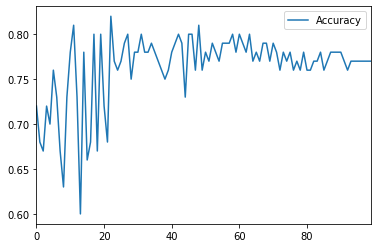

In [10]:
dataframes['Direct'][1].plot()

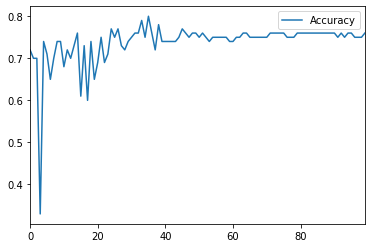

In [11]:
dataframes['Direct'][2].plot()

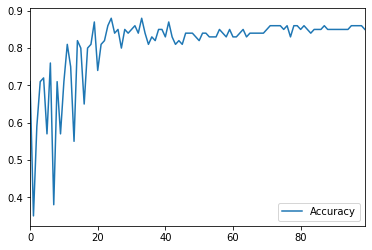

In [13]:
dataframes['Direct'][3].plot()

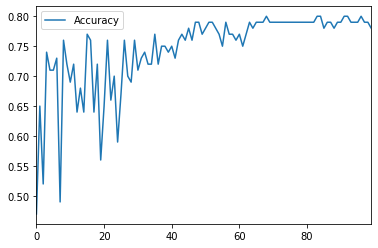

In [14]:
dataframes['Direct'][4].plot()

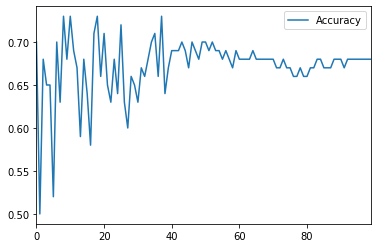

In [15]:
dataframes['Direct'][5].plot()

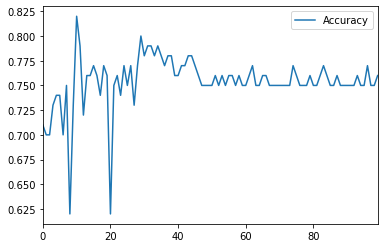

In [16]:
dataframes['MURA'][1].plot()

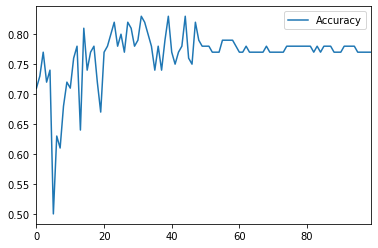

In [17]:
dataframes['MURA'][2].plot()

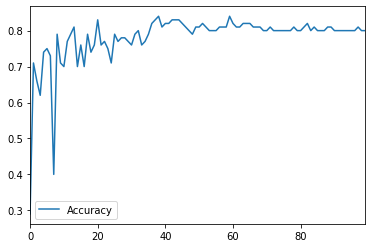

In [18]:
dataframes['MURA'][3].plot()

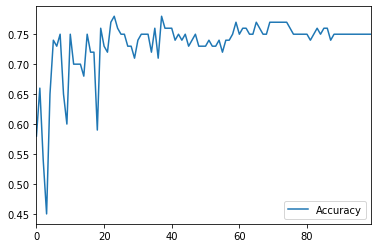

In [19]:
dataframes['MURA'][4].plot()

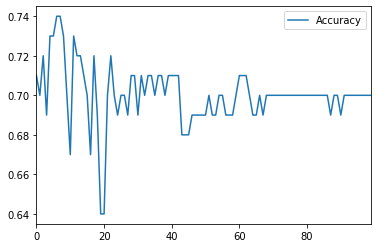

In [20]:
dataframes['MURA'][5].plot()

In [22]:
dataframes['MURA'][5]

,Epoch,Accuracy
0,0.h5,0.71
1,1.h5,0.70
2,2.h5,0.72
3,3.h5,0.69
4,4.h5,0.73
...,...,...
95,95.h5,0.70
96,96.h5,0.70
97,97.h5,0.70
98,98.h5,0.70


In [21]:
import matplotlib.pyplot as plt

In [27]:
for strategy in ['Direct','MURA']:
    for cv in np.arange(1,6):
        fig_name = strategy+'_CV'+str(cv)+'_Testing Accuracy Across Epoches.png'
        fig = plt.title(fig_name.replace('.png',''))
        fig = plt.xlabel('Epoches')
        fig = plt.ylabel('Accuracy')
        fig = plt.plot(range(0,100),dataframes[strategy][cv]['Accuracy'])
        fig = plt.ylim((0,1.))
        fig = plt.xticks(np.arange(1, 100, 5))
        fig = plt.legend()
        fig_save_path = './Epoch_Testings/'+fig_name
        fig.figure.savefig(fig_save_path)
        plt.clf()

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

In [29]:
import pickle

In [32]:
with open('./Epoch_Testings/dataframes.pickle',mode='wb') as f:
    pickle.dump(dataframes,f)